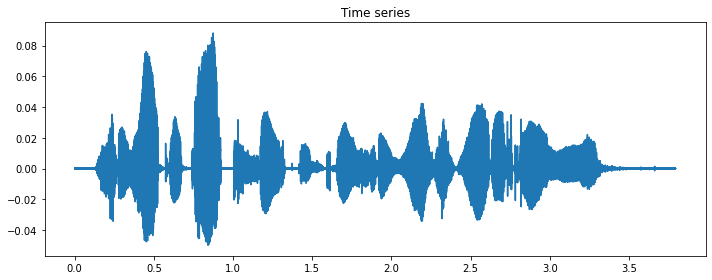

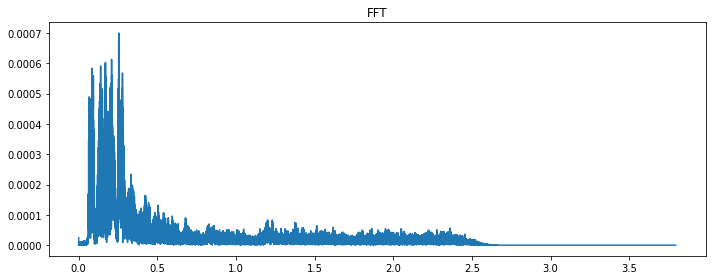

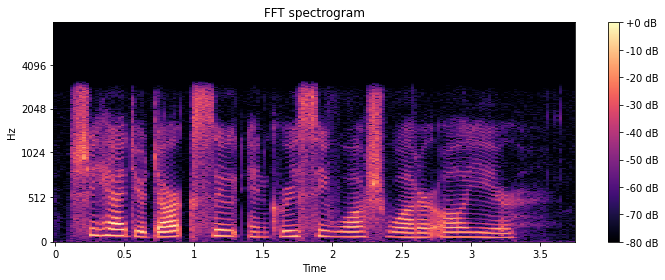

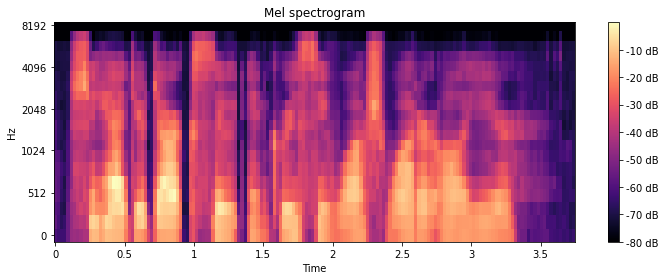

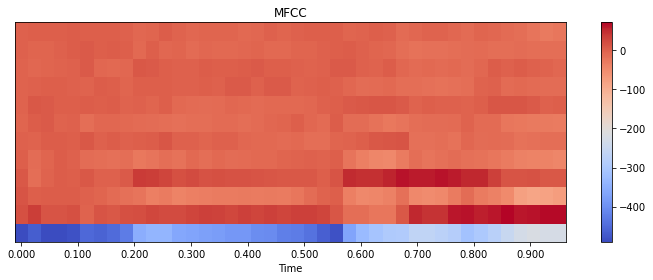

In [49]:
%matplotlib inline

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack


y, sr = librosa.load('dataset/Female_SA1_61.wav')
# y, sr = librosa.load('../../audio-recognition/speech_commands_v0.01/no/fffcabd1_nohash_0.wav')
duration = len(y) / sr

# Plot the time series.
plt.figure(figsize=(10, 4))
plt.title('Time series')
t = [float(i)/sr for i, _ in enumerate(y)]
plt.plot(t, y)
plt.tight_layout()

# Plot the fft from scipy.
yf = scipy.fftpack.fft(y)
N = len(yf)
xf = np.linspace(0.0, duration, int(N/2))
# xf = np.linspace(0.0, duration, N/2)
plt.figure(figsize=(10, 4))
plt.title('FFT')
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.tight_layout()

D = np.abs(librosa.stft(y, n_fft=1024, hop_length=512, center=False))**2

# Show regular spectrogram.
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(D, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('FFT spectrogram')
plt.tight_layout()


# Show Mel spectrogram.
S = librosa.feature.melspectrogram(S=D, n_mels=20)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# Save the spectrogram as an image.
# import scipy.misc
# scipy.misc.imsave('spec-librosa.png', mfccs)
# Save the spectrogram as an image using matplotlib
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.savefig('spec-librosa.png')


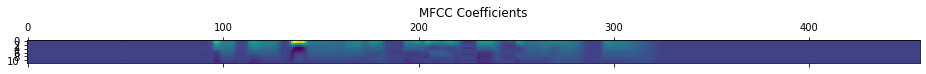

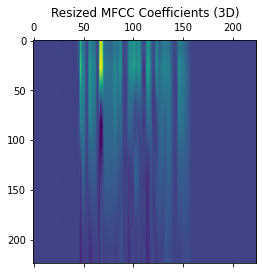

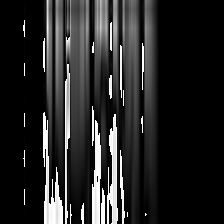

255 0 38.462611607142854


In [27]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.fftpack import dct
from skimage.transform import resize
from PIL import Image

# Function to compute STFT
def stft(signal, n_fft=2048, hop_length=512):
    return librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# Function to compute Mel Filters
def mel_filters(sr, n_fft, n_mels=40):
    return librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

# Function to compute Mel Spectrogram
def mel_spectrogram(signal, sr, n_fft=2048, hop_length=512):
    spectrogram = np.abs(stft(signal, n_fft=n_fft, hop_length=hop_length))
    mel_filters_matrix = mel_filters(sr, n_fft)
    mel_spectrogram = np.dot(mel_filters_matrix, spectrogram)
    return mel_spectrogram

# Function to compute MFCC
def mfcc(signal, sr, n_fft=2048, hop_length=512, n_mfcc=12):
    mel_spec = mel_spectrogram(signal, sr, n_fft=n_fft, hop_length=hop_length)
    log_mel_spec = np.log1p(mel_spec)
    mfcc_coefficients = dct(log_mel_spec, type=2, axis=0, norm='ortho')[:n_mfcc]
    return mfcc_coefficients

# Function to resize image
def resize_image(image, target_size=(224, 224, 3)):
    return resize(np.rollaxis(np.array([image] * 3), 0, 3), target_size)

# Load WAV file
wav_file_path = '../../Data/3666/Female_21964749.wav'
signal, sample_rate = librosa.load(wav_file_path, sr=None)

# Compute MFCC
mfc = mfcc(signal, sample_rate)

# Display MFCC
plt.matshow(mfc)
plt.title('MFCC Coefficients')
plt.show()

# Resize MFCC
mfc_3d = resize_image(mfc)

# Display Resized MFCC
plt.matshow(mfc_3d[:, :, 2])  # Displaying the second channel
plt.title('Resized MFCC Coefficients (3D)')
plt.show()

# Convert to image using PIL
mfc_img = Image.fromarray((mfc_3d * 255).astype(np.uint8))
# Display the last image
mfc_img.show()

# Display image statistics
print(np.array(mfc_img).max(), np.array(mfc_img).min(), np.array(mfc_img).mean())
# Save the image
save_path = 'path_to_save_image.jpg'
mfc_img.save(save_path)


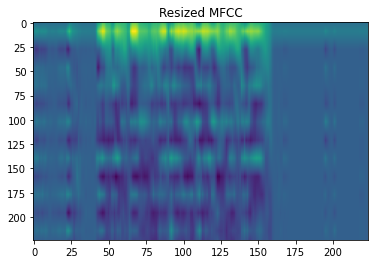

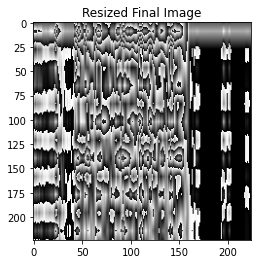

Initial MFCC size: (12, 457)


In [52]:
import os
import numpy as np
import scipy.io.wavfile
import librosa
from skimage.transform import resize
import matplotlib.pyplot as plt
import scipy.misc

# Constants
kPRE_EMPHASIS_COEFF = 0.97
sample_rate = 100000
max_duration = 0.9999583333333333
max_samples = int(max_duration * sample_rate)

def pad_signal(signal, target_len):
    num_zeros_needed = target_len - len(signal)
    if num_zeros_needed > 0:
        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')
    else:
        return signal

def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

def pipeline(signal):
    emphasized_signal = pre_emphasis(signal)
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft=int(sample_rate * 0.025),
        hop_length=int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hamming',
        n_mels=40
    )

    return lifted_mfcc
def resize_mfcc_and_final(mfcc, target_size=(224, 224, 3)):
    resized_mfcc = resize(mfcc, target_size[:2])
    resized_final = resize(np.rollaxis(np.array([resized_mfcc] * 3), 0, 3), target_size)
    return resized_mfcc, resized_final

def preprocess_and_display(wav_file_path):
    _, signal = scipy.io.wavfile.read(wav_file_path)
    signal = pad_signal(signal, target_len=max_samples)

    mfc = pipeline(signal)

    # Resize both MFCC and final MFCC to the same target size
    resized_mfcc, resized_final = resize_mfcc_and_final(mfc)

    # Display the resized mfcc
    plt.imshow(resized_mfcc, aspect='auto', cmap='viridis')
    plt.title('Resized MFCC')
    plt.show()

    # Display the resized final mfcc
    plt.imshow(resized_final.astype(np.uint8))
    plt.title('Resized Final Image')
    plt.show()

# Example usage:
wav_file_path = '../../Data/3666/Female_21964749.wav'
preprocess_and_display(wav_file_path)



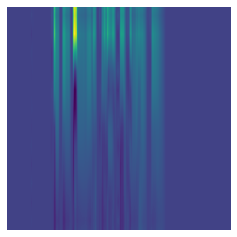

In [36]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.fftpack import dct
from skimage.transform import resize
from PIL import Image

# Function to compute STFT
def stft(signal, n_fft=2048, hop_length=512):
    return librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# Function to compute Mel Filters
def mel_filters(sr, n_fft, n_mels=40):
    return librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

# Function to compute Mel Spectrogram
def mel_spectrogram(signal, sr, n_fft=2048, hop_length=512):
    spectrogram = np.abs(stft(signal, n_fft=n_fft, hop_length=hop_length))
    mel_filters_matrix = mel_filters(sr, n_fft)
    mel_spectrogram = np.dot(mel_filters_matrix, spectrogram)
    return mel_spectrogram

# Function to compute MFCC
def mfcc(signal, sr, n_fft=2048, hop_length=512, n_mfcc=12):
    mel_spec = mel_spectrogram(signal, sr, n_fft=n_fft, hop_length=hop_length)
    log_mel_spec = np.log1p(mel_spec)
    mfcc_coefficients = dct(log_mel_spec, type=2, axis=0, norm='ortho')[:n_mfcc]
    return mfcc_coefficients

# Function to resize image
def resize_image(image, target_size=(224, 224, 3)):
    return resize(np.rollaxis(np.array([image] * 3), 0, 3), target_size)

# Load WAV file
wav_file_path = '../../Data/3666/Female_21964749.wav'
signal, sample_rate = librosa.load(wav_file_path, sr=None)

# Compute MFCC
mfc = mfcc(signal, sample_rate)

# Resize MFCC
mfc_3d = resize_image(mfc)

# Display Resized MFCC without labels and titles
plt.matshow(mfc_3d[:, :, 2], cmap='viridis')  # Displaying the second channel without labels
plt.axis('off')  # Turn off axis labels
plt.title('')  # Remove the title
save_path = 'path_to_save_image.jpg'
plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


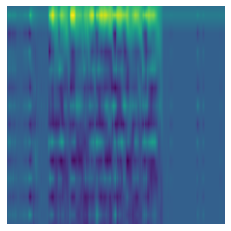

In [66]:
import os
import numpy as np
import scipy.io.wavfile
import librosa
from skimage.transform import resize
import matplotlib.pyplot as plt

# Constants
kPRE_EMPHASIS_COEFF = 0.97
sample_rate = 100000
max_duration = 0.9999583333333333
max_samples = int(max_duration * sample_rate)

def pad_signal(signal, target_len):
    num_zeros_needed = target_len - len(signal)
    if num_zeros_needed > 0:
        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')
    else:
        return signal

def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - kPRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

def pipeline(signal):
    emphasized_signal = pre_emphasis(signal)
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft=int(sample_rate * 0.025),
        hop_length=int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hamming',
        n_mels=40
    )

    return lifted_mfcc

def resize_mfcc_and_final(mfcc, target_size=(224, 224, 3)):
    resized_mfcc = resize(mfcc, target_size[:2])
    resized_final = resize(np.rollaxis(np.array([resized_mfcc] * 3), 0, 3), target_size)
    return resized_mfcc, resized_final

def preprocess_and_display(wav_file_path):
    _, signal = scipy.io.wavfile.read(wav_file_path)
    signal = pad_signal(signal, target_len=max_samples)

    mfc = pipeline(signal)

    # Resize both MFCC and final MFCC to the same target size
    resized_mfcc, resized_final = resize_mfcc_and_final(mfc)

    plt.imshow(resized_mfcc)
    plt.axis('off')
    save_path = 'path_to_save_imagAAAe.jpg'
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

# Example usage:
wav_file_path = '../../Data/3666/Female_21964749.wav'
preprocess_and_display(wav_file_path)
